In [1]:
import pickle
from transformers import AutoTokenizer
import numpy as np
import shap
from src.plot_text import text, get_grouped_vals

# from src.utils import format_fts_for_plotting, text_ft_index_ends, token_segments
# from src.utils import legacy_get_dataset_info
from datasets import load_dataset

# import matplotlib.pyplot as plt
from src.run_shap import load_shap_vals
from tqdm import tqdm

# import re
# import seaborn as sns
# from scipy import stats
from src.utils import (
    ConfigLoader,
    text_ft_index_ends,
    token_segments,
    format_fts_for_plotting,
    format_text_fts_too,
)

In [2]:
# open from pickle
with open("/home/james/CodingProjects/ExplainPetBERT/all_tokens.pkl", "rb") as f:
    all_tokens = pickle.load(f)

In [3]:
all_tokens

array(['neutered = yes   Blood_or_Blood-forming = 0   Dental = 4   Digestive = 1   Circulatory = 0   Endocrine_Nutritional_or_Metabolic = 1   Genitourinary = 1   ',
       'insured = False   species = cat   Neoplasms = 0   Ear_or_Mastoid = 0   Infectious_or_Parasitic = 2   Immune = 0   Skin = 0   Developmental = 0   Musculoskeletal_or_Connective_Tissue = 0   Injury_Poisoning_or_External_Causes = 0   Perinatal = 0   Pregnancy_Childbirth_or_Puerperium = 0   Mental_Behavioral_or_Neuro = 1   Nervous = 0   Visual = 0   Respiratory = 0   ',
       'gender = female   ', 'age_at_consult = 12.06   ',
       '(Text ft) breed = missing   (Text ft) region = Rot   herham',
       '(Text ft) record = owner    rep not quite ', 'hersel.  ',
       'either really hungry or eating very little.  ', 'occ v+ chronic ',
       'hx-last time tuesday, ', 'not after food, ', 'no blood. ',
       'time before that last week.  ', 'been on bland white ',
       'fish for 1 week. ', 'no d+last few weeks, ', 'occ h

## Testing summary plot function

Updating with:
{'config': 'vet_10c_all_text', 'my_text_model': 'james-burton/vet_10c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'bert-base-uncased', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating in the per

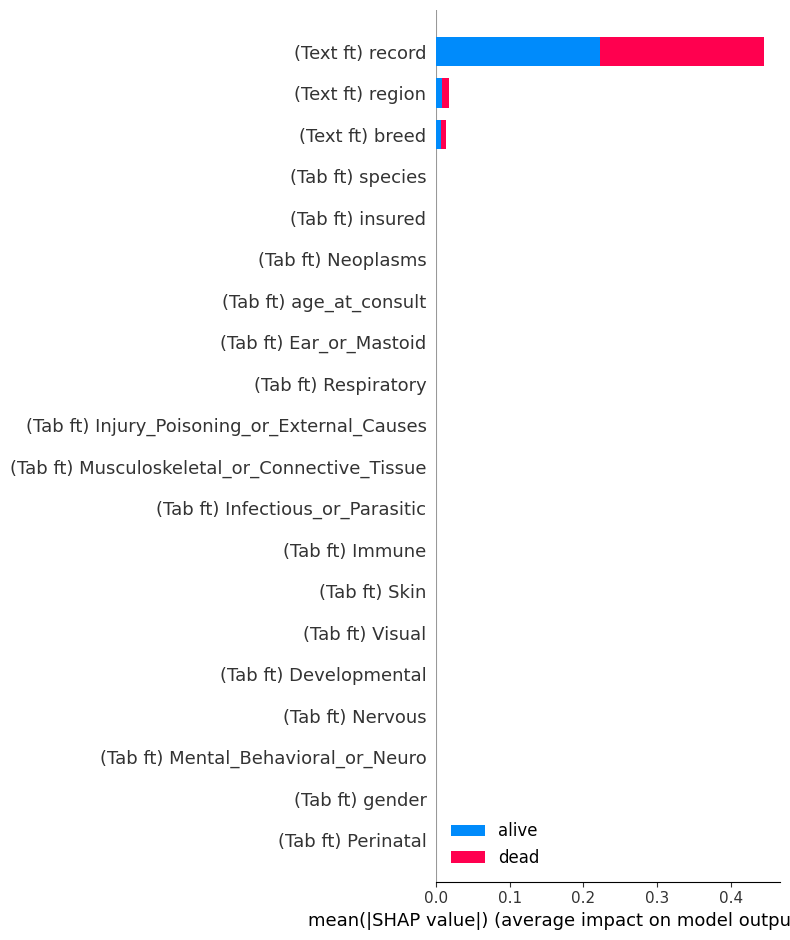

Updating with:
{'config': 'vet_50c_all_text', 'my_text_model': 'james-burton/vet_50c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'SAVSNET/PetBERT_pretrained', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating i

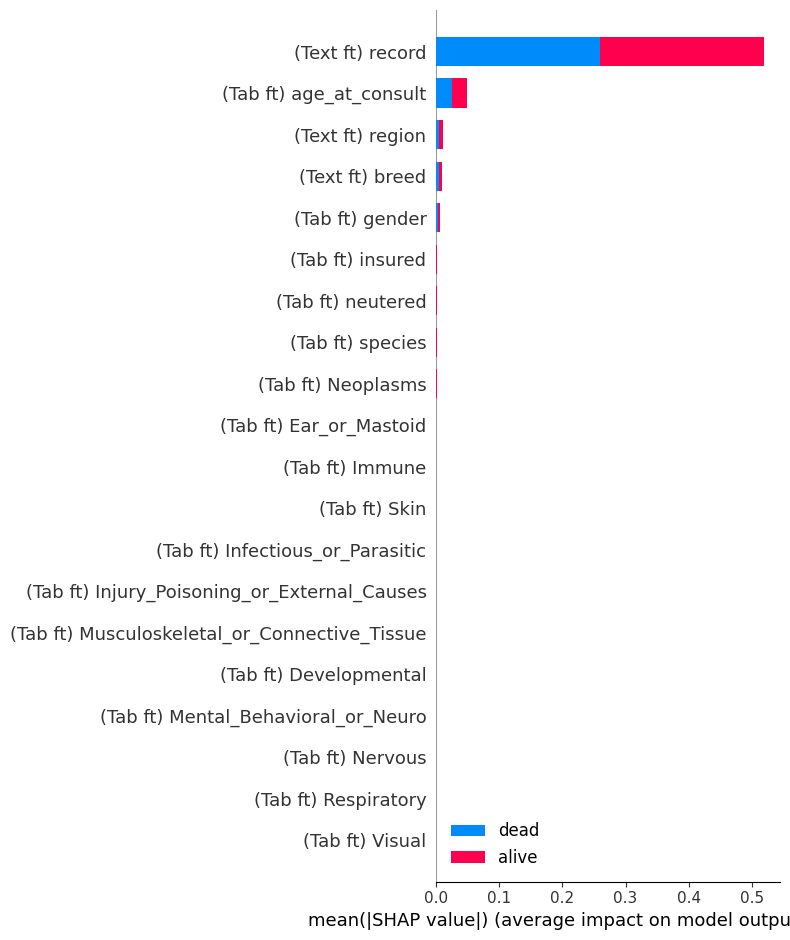

In [9]:
# checking summary shap vals
config_name = "vet_10c_all_text"
with open(f"../models/shap_vals/summed_{config_name}.pkl", "rb") as f:
    grouped_shap_vals = pickle.load(f)

args = ConfigLoader(
    config_name, "../configs/shap_configs.yaml", "../configs/dataset_default.yaml"
)
shap.summary_plot(
    list(grouped_shap_vals),
    features=[
        f"(Tab ft) {col}" for col in args.categorical_cols + args.numerical_cols]
    + [f"(Text ft) {col}" for col in args.text_cols],
    class_names=args.label_names,
)
# checking summary shap vals
config_name = "vet_50c_all_text"
with open(f"../models/shap_vals/summed_{config_name}.pkl", "rb") as f:
    grouped_shap_vals = pickle.load(f)

args = ConfigLoader(
    config_name, "../configs/shap_configs.yaml", "../configs/dataset_default.yaml"
)
shap.summary_plot(
    list(grouped_shap_vals),
    features=[
        f"(Tab ft) {col}" for col in args.categorical_cols + args.numerical_cols]
    + [f"(Text ft) {col}" for col in args.text_cols],
    class_names=args.label_names,
)

## Testing normal plot function

In [5]:
def display_shap_vals(config_name, idx, add_spacing=False):
    args = ConfigLoader(
        config_name, "../configs/shap_configs.yaml", "../configs/dataset_default.yaml"
    )
    shap_vals = load_shap_vals(config_name, add_parent_dir=True)

    if "baseline" in config_name:
        shap.plots.text(
            shap.Explanation(
                values=shap_vals[idx].values,
                base_values=shap_vals[idx].base_values,
                data=shap_vals[idx].data,
                clustering=shap_vals[idx].clustering,
                output_names=args.label_names,
                hierarchical_values=shap_vals[idx].hierarchical_values,
            ),
            # grouping_threshold=10,
        )
    else:
        # To format the text features, we find when the text features end and therefore
        # where to insert linebreaks
        tokenizer = AutoTokenizer.from_pretrained(args.text_model_base)
        text_idxs = text_ft_index_ends(
            text_fts=shap_vals.data[idx][
                len(args.categorical_cols + args.numerical_cols):
            ],
            tokenizer=tokenizer,
        )
        linebreak_before_idxs = [len(args.categorical_cols + args.numerical_cols)] + [
            x + len(args.categorical_cols + args.numerical_cols) + 1 for x in text_idxs
        ]

        formatted_data = np.array(
            format_fts_for_plotting(
                shap_vals[idx].feature_names,
                shap_vals[idx].data[: len(
                    args.categorical_cols + args.numerical_cols)],
            )
        )
        if add_spacing:
            text(
                shap.Explanation(
                    values=shap_vals[idx].values,
                    base_values=shap_vals[idx].base_values,
                    data=formatted_data,
                    clustering=shap_vals[idx].clustering,
                    output_names=args.label_names,
                    hierarchical_values=shap_vals[idx].hierarchical_values,
                ),
                # grouping_threshold=20,
                linebreak_before_idxs=linebreak_before_idxs,  # linebreak_after_idx,
                text_cols=args.text_cols,
                grouping_threshold=1,
            )
        else:
            formatted_data = format_text_fts_too(
                formatted_data,
                linebreak_before_idxs,
                args.text_cols,
            )
            shap.text_plot(
                shap.Explanation(
                    values=shap_vals[idx].values,
                    base_values=shap_vals[idx].base_values,
                    data=formatted_data,
                    clustering=shap_vals[idx].clustering,
                    output_names=args.label_names,
                    hierarchical_values=shap_vals[idx].hierarchical_values,
                ),
                # grouping_threshold=20,
                # grouping_threshold=10,
            )

In [6]:
display_shap_vals("vet_10c_baseline", 0)

Updating with:
{'config': 'vet_10c_baseline', 'my_text_model': 'james-burton/vet_10c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'bert-base-uncased', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating in the per

In [7]:
display_shap_vals("vet_10c_all_text", 60)

Updating with:
{'config': 'vet_10c_all_text', 'my_text_model': 'james-burton/vet_10c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'bert-base-uncased', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating in the per

In [8]:
display_shap_vals("vet_50c_all_text", 99)
# display_shap_vals("vet_19c_ensemble_25", 25)
# display_shap_vals("vet_19c_ensemble_50", 25)
# display_shap_vals("vet_19c_ensemble_75", 25)
# display_shap_vals("vet_19c_stack", 25)

Updating with:
{'config': 'vet_50c_all_text', 'my_text_model': 'james-burton/vet_50c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'SAVSNET/PetBERT_pretrained', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating i

## Testing bar plots with words

In [ ]:
config_name = "vet_10c_baseline"
args = ConfigLoader(
    config_name, "../configs/shap_configs.yaml", "../configs/dataset_default.yaml"
)
shap_vals = load_shap_vals(config_name, add_parent_dir=True)

Updating with:
{'config': 'vet_10c_baseline', 'my_text_model': 'james-burton/vet_10c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'bert-base-uncased', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating in the per

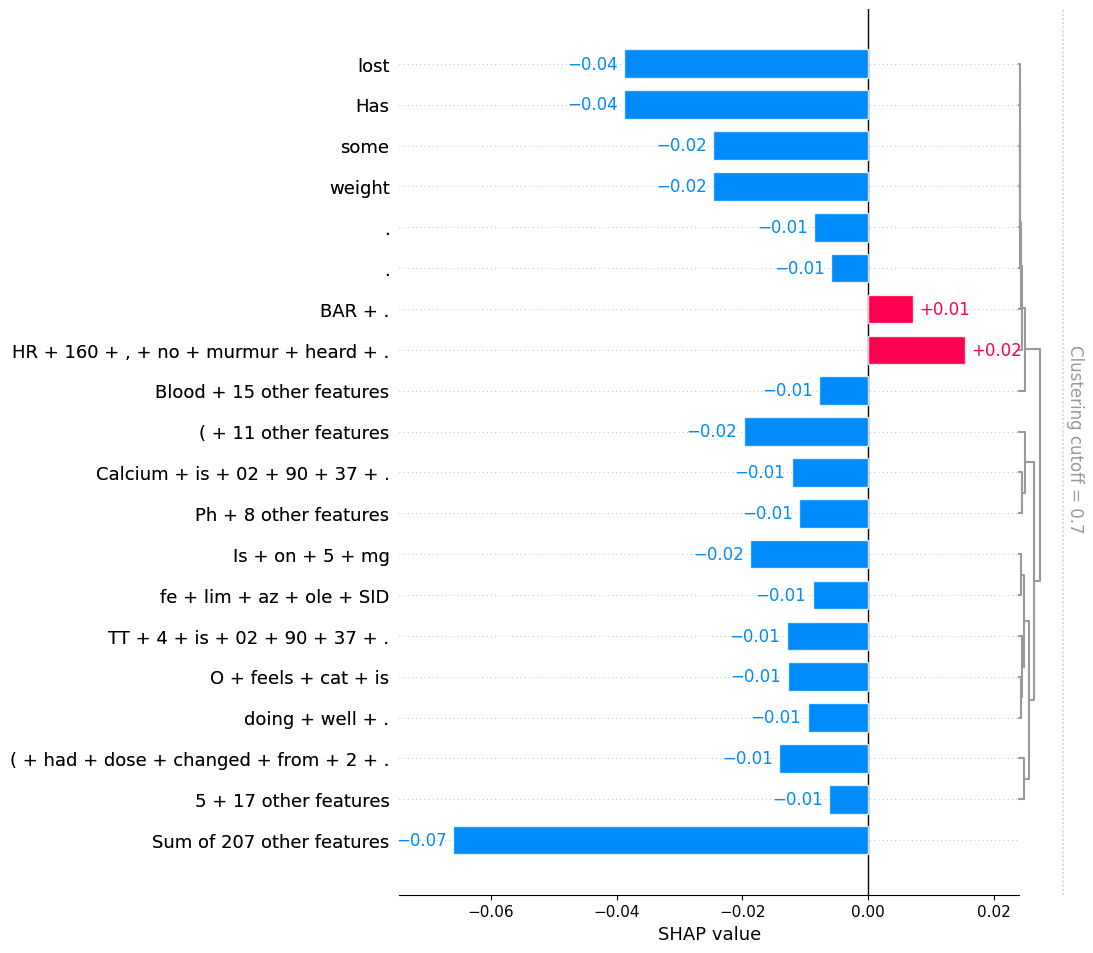

In [ ]:
shap.plots.bar(
    shap_vals[99, :, 0],
    clustering_cutoff=0.7,
    max_display=20,
    order=shap.Explanation.argsort,
)
# shap.plots.bar(shap_values[0,:,"POSITIVE"])

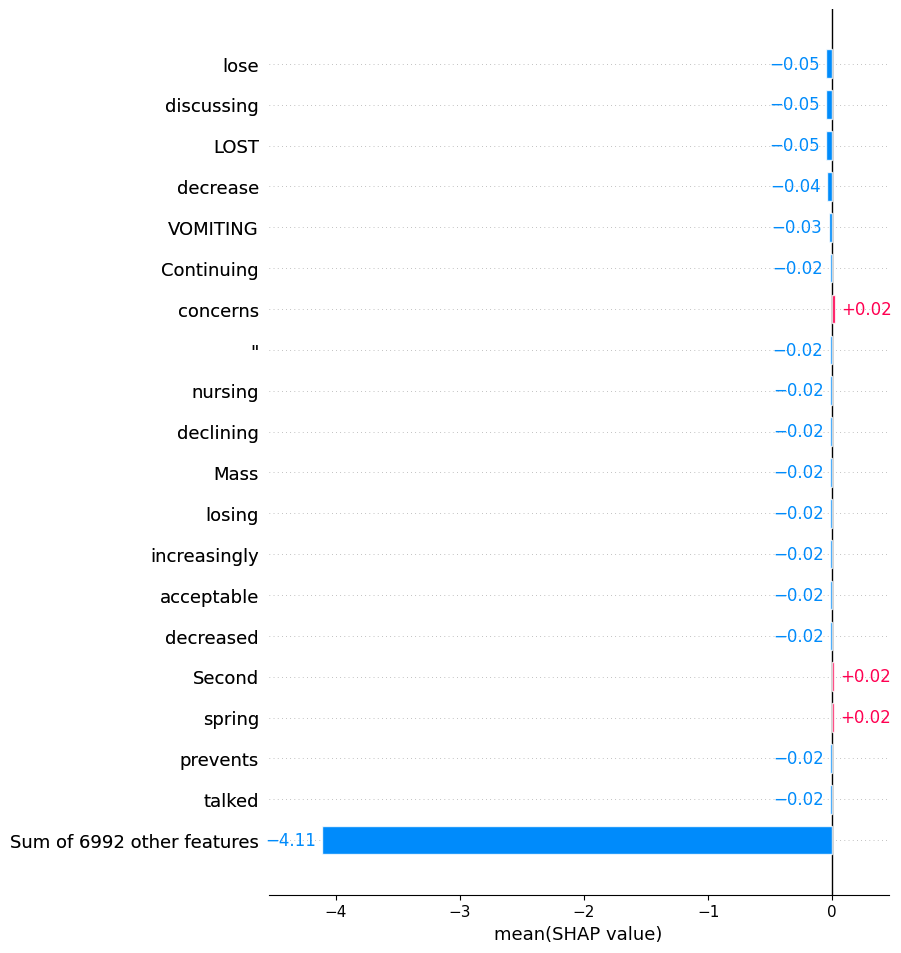

In [ ]:
shap.plots.bar(shap_vals[:, :, 0].mean(0), max_display=20)

In [ ]:
config_name = "vet_19c_ensemble_25"
idx = 99

args = ConfigLoader(
    config_name, "../configs/shap_configs.yaml", "../configs/dataset_default.yaml"
)
shap_vals = load_shap_vals(config_name, add_parent_dir=True)

tokenizer = AutoTokenizer.from_pretrained(args.text_model_base)
text_idxs = text_ft_index_ends(
    text_fts=shap_vals.data[idx][len(
        args.categorical_cols + args.numerical_cols):],
    tokenizer=tokenizer,
)
linebreak_before_idxs = [len(args.categorical_cols + args.numerical_cols)] + [
    x + len(args.categorical_cols + args.numerical_cols) + 1 for x in text_idxs
]

formatted_data = np.array(
    format_fts_for_plotting(
        shap_vals[idx].feature_names,
        shap_vals[idx].data[: len(
            args.categorical_cols + args.numerical_cols)],
    )
)

formatted_data = format_text_fts_too(
    formatted_data,
    linebreak_before_idxs,
    args.text_cols,
)

Updating with:
{'config': 'vet_19c_ensemble_25', 'my_text_model': 'james-burton/vet_19c', 'ds_name': 'james-burton/vet_month_1c_ordinal', 'text_model_base': 'bert-base-uncased', 'model_type': 'ensemble_25', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating in th

In [ ]:
from src.utils import text

tokens, values = text(
    shap.Explanation(
        values=shap_vals[idx].values,
        base_values=shap_vals[idx].base_values,
        data=formatted_data,
        clustering=shap_vals[idx].clustering,
        output_names=args.label_names,
        hierarchical_values=shap_vals[idx].hierarchical_values,
    ),
    # grouping_threshold=20,
    grouping_threshold=0.1,
    display=True,
)

In [20]:
abs(grouped_shap_vals[:, :, -1]).mean(1)

array([0.25940501, 0.25940501])